### Char-level Language Modeling - Part 2
In this series, we will be building char-level bi-gram language models:
* ~~[Bi-gram count based language model]()~~
* **Bi-gram neural network based language model**

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

We would like to formulate the bigram NN-LM as a supervised learning, given an input character, the neural network will output the next character.\
For this, we need a dataset of pairs of (X, y), X is input character and y is the next character (target/label)\
In a bigram model, X (input) will be the first character of bigram (context of one character) and y (target) will be the second character of bigram.

We will be using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) used in Andrej Karpathy's makemore lecture series.

In [21]:
with open("names.txt",'r') as file:
    names = file.read().splitlines()

In [22]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

#### Let's create the dataset for NN model:
First, create character to index mapping and index to character mapping (same as bigram count model)

In [23]:
# let's create a character vocabulary for names dataset and also add ".", the start token to the vocab
char_vocab = ['.'] + sorted(set("".join(names)))
vocab_size = len(char_vocab)
print(f"{vocab_size=} and characters in vocab: {''.join(char_vocab)}")

# character to index mapping
chartoi = {}
# index to character mapping
itochar = {}
for i, c in enumerate(char_vocab):
    chartoi[c] = i
    itochar[i] = c
print(f"{chartoi=}")
print(f"{itochar=}")

vocab_size=27 and characters in vocab: .abcdefghijklmnopqrstuvwxyz
chartoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itochar={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [24]:
# compute all the bigrams for names
X = []
y = [] 
for i, name in enumerate(names):
    name = '.' + name + '.'
    for ch1, ch2 in zip(name[:-1],name[1:]):
        X.append(chartoi[ch1])
        y.append(chartoi[ch2])
    if i == 0:
        print(f"For word '{name}': {X=} and {y=}")
print(f"No. of total examples in X: {len(X)}")

X = torch.tensor(X)
Y= torch.tensor(y)

print(f"{X[:10]=} and {y[:10]=}")

For word '.emma.': X=[0, 5, 13, 13, 1] and y=[5, 13, 13, 1, 0]
No. of total examples in X: 228146
X[:10]=tensor([ 0,  5, 13, 13,  1,  0, 15, 12,  9, 22]) and y[:10]=[5, 13, 13, 1, 0, 15, 12, 9, 22, 9]


Our dataset contains **228146** samples.

Giving an integer as input to a neural network doesn't make sense, so we will convert the integer index to a one-hot vector representation. Our vocabulary has 27 (`vocab_size`) unique character, therefore we need a one-hot vector of size 27. If the character has index *i*, then the one-hot vector will have *1* at *i-th* position and all the remaining positions will be zeros.

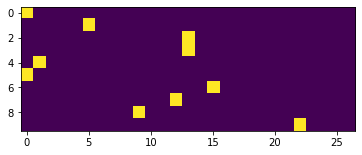

In [25]:
# pytorch has a in-built function for one-hot representation, torch.nn.functional.one_hot(tensor, num_classes=-1)
# convert integer to float data type for nn input

X_enc = F.one_hot(X, num_classes=27).float()

# visualize the one-hot representation of the inputs
plt.imshow(X_enc[:10])

#### Let's define our neural network architecture: 
We will use a single linear layer of 27 (`vocab_size`) hidden units (neurons) without bias and a output softmax layer.\
**One hidden layer**: 27 hidden units and takes an input one-hot vector of dimension 27, so the weight matrix, W, will be of shape (27x27).\
**Weight initialization**: Initialize the weight matrix, W, with random numbers from a standard normal distribution with mean 0 and variance 1. If W is initialized with all zeros or with some constant $\alpha$, then all the hidden units will learn the same features.\
We are using 27 hidden units (neurons), so that we can compare this W matrix with the `probs` matrix from bigram count-based LM in Part-1.

In [26]:
print(f"Total number parameter in NN: {27*27}")

Total number parameter in NN: 729


Text(0.5, 1.0, 'W (Initialized with Std. Normal distribution)')

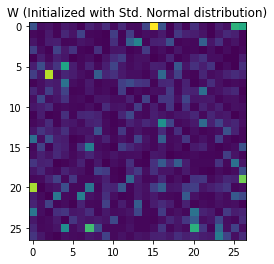

In [27]:
# for reproduciblity of results
g = torch.Generator().manual_seed(2147483647)
#weight matrix (learnable weights)
W = torch.randn((vocab_size,vocab_size), requires_grad=True, generator=g)

# visualize the weight matrix = log counts, therefore we need to take exponent to compare it with `probs` table
plt.imshow(W.exp().detach().numpy())
plt.title("W (Initialized with Std. Normal distribution)")
# plt.axis('off');

After training the NN, this weight matrix visualiztion should look similar to counts matrix in bigram count-based LM.\
**W, weight matrix = log counts or logits**, therefore we need to take exponent to compare it with `probs` table
#### To learn the weight matrix, W, we will use iterative gradient based optimization method like gradient descent.

2.4901304244995117 2.4901304244995117


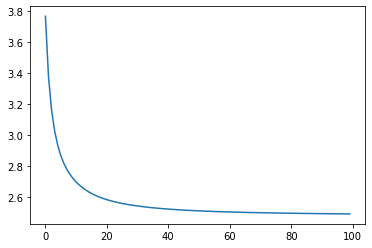

In [28]:
epochs = 100
n_samples = X_enc.shape[0]
# learning rate
lr = 50
nlls = []
# to keep track of min nll loss
min_nll = float('inf')

for _ in range(epochs):
    # equivalent to `torch.nn.Linear` with no bias
    logits = X_enc @ W
    # shape of logits = (n_samples x vocab_size)
    # softmax layer
    counts = logits.exp()
    probs = counts / counts.sum(dim=-1, keepdims=True)
    # loss (average negative log likelihood)
    nll = -probs[torch.arange(n_samples), Y].log().mean() + 0.01*(W**2).mean()

    # set gradients to zero and perform backpropagation
    W.grad = None
    nll.backward()

    # parameter update, inplace update
    W.data += -lr * W.grad

    if nll < min_nll:
        min_nll = nll.item()

    nlls.append(nll.item())

print(min_nll, nlls[-1])
plt.plot(nlls)

    

In [29]:
W.max(),W.min()

(tensor(3.8470, grad_fn=<MaxBackward1>),
 tensor(-2.4338, grad_fn=<MinBackward1>))

Visualize the learned weight matrix, W

Text(0.5, 1.0, 'W (learned weights)')

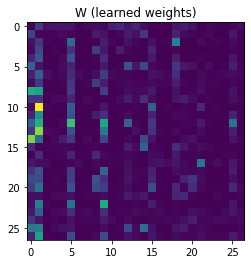

In [30]:
plt.imshow(W.exp().detach().numpy())
plt.title("W (learned weights)")
# plt.axis('off');

#### Generate new words using learned weight matrix, W.

In [31]:
# for reproduciblity of results
g = torch.Generator().manual_seed(2147483647)
n = 10 # generate n words
for i in range(n):
    # start token (idx)
    curr_idx = 0
    curr_word = ''
    while True:
        x_enc = F.one_hot(torch.tensor([curr_idx]), num_classes=27).float()
        logits = x_enc @ W #log counts
        counts = logits.exp()
        prob = counts / counts.sum(dim=-1, keepdims=True)
        # sample index of next character
        next_char_ix = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        curr_char = itochar[next_char_ix]
        curr_word += curr_char
        curr_idx = next_char_ix
        if curr_char == '.':
            print(curr_word)
            break

mor.
axx.
minaymoryles.
kondmaisah.
anchthizarie.
odaren.
iaddash.
h.
jionatien.
egwver.


Words generated by neural network LM are similar to bigram count-based LM. The next steps to further improve NN-LM would be to use non-linearity to increase model complexity and also experimenting with N-grams (longer context).